Цель - провести обучение модели на текстовых данных, так чтобы она могла распознавать тональность отзыва.

In [1]:
#загрузим библиотеки
import pandas as pd
import numpy as np
from sklearn import datasets
import seaborn as sns
import datetime

import json
import requests
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 12]
from sklearn.metrics import *

import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm_notebook

# Предобработка.

In [2]:
df = pd.read_csv('C:\\Users\\algol\\Downloads\\IMDB Dataset.csv.zip', compression='zip')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
df.head()

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends.",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zom

Датафрейм представляет тексты отзывов на фильмы и оценки положительный/отрицательный. 

In [3]:
#проверим имеющиеся значения в колонке sentiment
df['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

In [4]:
#проверим пропуски
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [5]:
#найдем долю дубликатов
df.duplicated().mean()

0.00836

Т.к. дубликатов меньше процента можно удалить. 

In [6]:
df=df.drop_duplicates().reset_index(drop = True)

In [7]:
#проверим остались ли дубликаты
df.duplicated().mean()

0.0

In [8]:
#уменьшим датафрейм до 1000 отзывов

In [9]:
# #это было сделано для возможности "дебажить" с минимумом времени, теперь используем весь датафрейм
# df = df[0:1000]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49582 entries, 0 to 49581
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     49582 non-null  object
 1   sentiment  49582 non-null  object
dtypes: object(2)
memory usage: 774.8+ KB


## Пробуем токенизацию и удаление стоп-слов

In [11]:
import string # библиотека для работы со строками
import nltk   # Natural Language Toolkit

<span style="color:green"> (2)Переделаем список в датафрейм для ускорения.</span>

In [12]:
# загружаем список стоп-слов для английского
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
#**переделаем список в датафрейм для ускорения**
stop_wor_df = pd.DataFrame(data = stop_words)
# примеры стоп-слов
stop_wor_df[:5]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\algol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,0
0,i
1,me
2,my
3,myself
4,we


In [13]:
# знаки препинания
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [14]:
exceptions = ['.<', '/><', '/>', '),', ').', '!!<', '....', '",', '."', '!!!', '...<', '...', 
              '***', '!?', '**', '--', ',<', '!!)', '000', ')<', '..........','??"', '".',')"',
              ').....','!)','.....',',"','.......', '!!!!!!','.)','/>-','..','!!!!!!!!!!!!!', '/>"',
              ').<',"''","'').","''", '!).']


In [15]:
#Инициализируем WordPunctTokenizer, с помощью 
#которого затем разобьем текст на слова.
word_tokenizer = nltk.WordPunctTokenizer()
#word_tokenizer.tokenize('Michael Imperioli, Adrian Grenier, and the rest of the talented cast, make.<br /><br />We wish')

## Токенизация и удаление стоп-слов с помощью цикла

In [16]:
from nltk.tokenize import word_tokenize
 
#уберем даты и цифры
dates = [str(x) for x in np.arange(0, 2022)]
texts = []
     # поочередно проходим по всем отзывам 
for i in range(len(df)):
    text_lower = df.iloc[i, 0].lower() # приводим все слова к нижнему регистру
    tokens     = word_tokenizer.tokenize(text_lower)
         # удаляем пунктуацию и стоп-слова
    tokens = [word for word in tokens if (word not in string.punctuation and word not in stop_words \
                            and word not in dates and word not in exceptions)]
    texts.append(tokens) # добавляем в предобработанный список
   

<span style="color:green"> (3)Переделаем список в массив для ускорения.</span>

In [17]:
texts= np.asarray(texts)
texts

array([list(['one', 'reviewers', 'mentioned', 'watching', 'oz', 'episode', 'hooked', 'right', 'exactly', 'happened', 'br', 'br', 'first', 'thing', 'struck', 'oz', 'brutality', 'unflinching', 'scenes', 'violence', 'set', 'right', 'word', 'go', 'trust', 'show', 'faint', 'hearted', 'timid', 'show', 'pulls', 'punches', 'regards', 'drugs', 'sex', 'violence', 'hardcore', 'classic', 'use', 'word', 'br', 'br', 'called', 'oz', 'nickname', 'given', 'oswald', 'maximum', 'security', 'state', 'penitentary', 'focuses', 'mainly', 'emerald', 'city', 'experimental', 'section', 'prison', 'cells', 'glass', 'fronts', 'face', 'inwards', 'privacy', 'high', 'agenda', 'em', 'city', 'home', 'many', 'aryans', 'muslims', 'gangstas', 'latinos', 'christians', 'italians', 'irish', 'scuffles', 'death', 'stares', 'dodgy', 'dealings', 'shady', 'agreements', 'never', 'far', 'away', 'br', 'br', 'would', 'say', 'main', 'appeal', 'show', 'due', 'fact', 'goes', 'shows', 'dare', 'forget', 'pretty', 'pictures', 'painted', 'm

In [18]:
# присваиваем целевую переменную
y = df['sentiment']

## Нормализация слов

In [19]:
from nltk.stem.snowball import SnowballStemmer 

# инициализируем стеммер
stemmer = SnowballStemmer("english")

In [20]:
# применяем стеммер ко всем текстам
for i in tqdm_notebook(range(len(texts))):   # создаем шкалу прогресса
    text_stemmed = [stemmer.stem(text) for text in texts[i]] # применяем стеммер для каждого слова в тексте
#     print(text_stemmed) 
#     break
    texts[i] = ' '.join(text_stemmed)


  0%|          | 0/49582 [00:00<?, ?it/s]

In [21]:
texts

array(['one review mention watch oz episod hook right exact happen br br first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use word br br call oz nicknam given oswald maximum secur state penitentari focus main emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home mani aryan muslim gangsta latino christian italian irish scuffl death stare dodgi deal shadi agreement never far away br br would say main appeal show due fact goe show dare forget pretti pictur paint mainstream audienc forget charm forget romanc oz mess around first episod ever saw struck nasti surreal say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard sold nickel inmat kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may becom comfort uncomfort view that get touch

# Моделирование

## Разбиваем на train/test

<span style="color:green"> (6)Переделаем кодирование целевой переменной.</span>

In [22]:
#закодируем ключевую переменную
encoded_y = y.apply(lambda x: 1 if x == 'positive' else 0)
encoded_y

0        1
1        1
2        1
3        0
4        1
5        1
6        1
7        0
8        0
9        1
10       0
11       0
12       0
13       0
14       1
15       0
16       1
17       0
18       1
19       0
20       1
21       0
22       1
23       0
24       0
25       1
26       1
27       0
28       0
29       1
30       1
31       1
32       0
33       1
34       0
35       0
36       0
37       0
38       1
39       0
40       0
41       1
42       0
43       0
44       1
45       1
46       0
47       0
48       1
49       0
50       1
51       1
52       1
53       1
54       0
55       0
56       0
57       0
58       1
59       1
60       0
61       0
62       1
63       0
64       0
65       1
66       0
67       0
68       0
69       0
70       0
71       0
72       1
73       1
74       0
75       1
76       1
77       0
78       0
79       1
80       1
81       0
82       0
83       0
84       0
85       0
86       0
87       0
88       0
89       0
90       1

In [23]:
# # Создадим функцию для кодирования лейблов целевой переменной
# def label2num(y):
#     if y == 'positive':
#         return 1
#     if y == 'negative':
#         return -1
# #применим функцию    
# encoded_y = [label2num(yy) for yy in y]

In [24]:
#Разделим на трайн и тест
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_y, test_y = train_test_split(texts, encoded_y, test_size=0.2, random_state=42, stratify = y)

## Применим для векторизации модель tf-idf к токенам

<span style="color:green"> (7)Переделаем max_feutures на min_df и max_df. Значения параметров выбрал интуитивно. Выскакивала ошибка, что не хватает памяти я max снизил, а min прибавил, чтобы больше отсеять. </span>

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Обучим TF-IDF на тренировочных данных
vectorizer = TfidfVectorizer(max_df = 0.60, min_df = 40, norm = None) # возмем топ 1000 слов
vectorizer.fit(train_texts)
#выведем топ 10 слов
vectorizer.get_feature_names()[:10]

['00',
 '13th',
 '18th',
 '1920s',
 '1930s',
 '1940s',
 '1950s',
 '1960s',
 '1970s',
 '1980s']

In [26]:
# Обучаем vectorizer на train-данных и сразу преобразем их в вектора с помощью метода fit_transform
train_X = vectorizer.fit_transform(train_texts)
train_X.todense()[:2]

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [27]:
#применяем векторайзер к тестовым данным
test_X  = vectorizer.transform(test_texts)

### Настроим регуляризацию модели логистической регрессии

In [28]:
from sklearn.linear_model import LogisticRegression
#напишем функцию для визуализации результатов
def show_results(test_y, pred, proba):
    print("Precision: {0:6.2f}".format(precision_score(test_y, pred, average='macro')))
    print("Recall: {0:6.2f}".format(recall_score(test_y, pred, average='macro')))
    print("F1-measure: {0:6.2f}".format(f1_score(test_y, pred, average='macro')))
    print("Accuracy: {0:6.2f}".format(accuracy_score(test_y, pred)))
    print("ROC-AUC  =  {0:6.2f}".format(roc_auc_score(test_y, proba[:,1]),))
    print('\n')
    labels = ['negative','positive']

    #classification_report
    sns.heatmap(data=confusion_matrix(test_y, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.title("Confusion matrix ")
    plt.show()

Best parameters:  {'C': 0.001, 'class_weight': None, 'penalty': 'l2'}
Precision:   0.89
Recall:   0.89
F1-measure:   0.89
Accuracy:   0.89
ROC-AUC  =    0.95




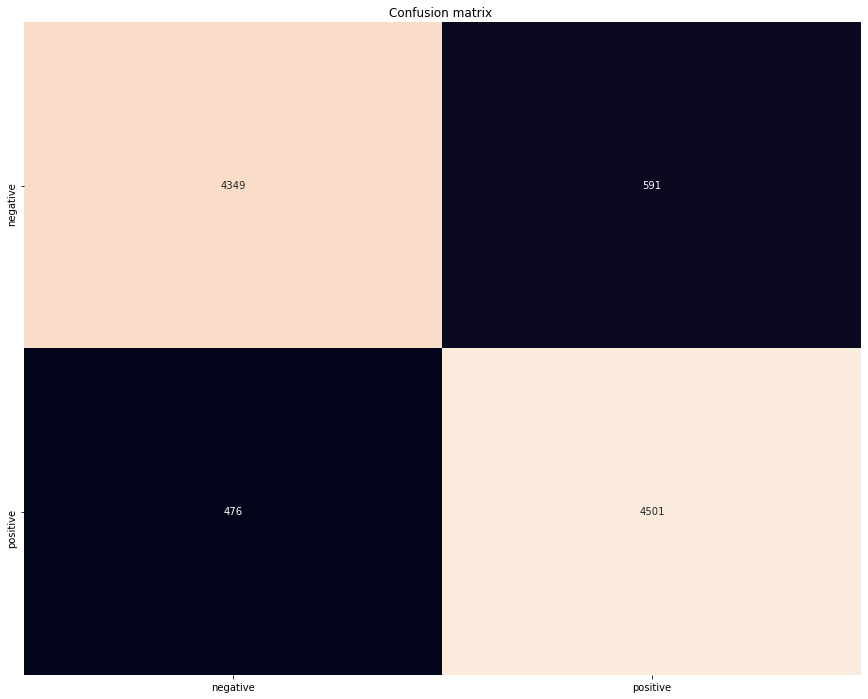

In [29]:
from sklearn.model_selection import GridSearchCV
#C - настройка регуляризации, class_weight - балансируем распределение по классам, 
# penalty - назначаем модели регуляризации для штрафов за переобучение
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight' : ['balanced',None],\
              'penalty':['l1', 'l2', 'elasticnet']}

svr = LogisticRegression(verbose = False)
clf = GridSearchCV(svr, parameters, scoring = 'f1')
clf.fit(train_X, train_y)
pred = clf.predict(test_X)
proba  = clf.predict_proba(test_X)
print('Best parameters: ', clf.best_params_)
show_results(test_y, pred, proba)

<span style="color:green"> (7)После изменения max_features на min_df и max_df class_weight зависит от значений max_df и min_df при определенных значениях менялся на balanced. Применим None.  </span>

### Подберем оптимальное количество признаков

Number of features:  100
Precision:   0.72
Recall:   0.72
F1-measure:   0.72
Accuracy:   0.72
ROC-AUC  =    0.80




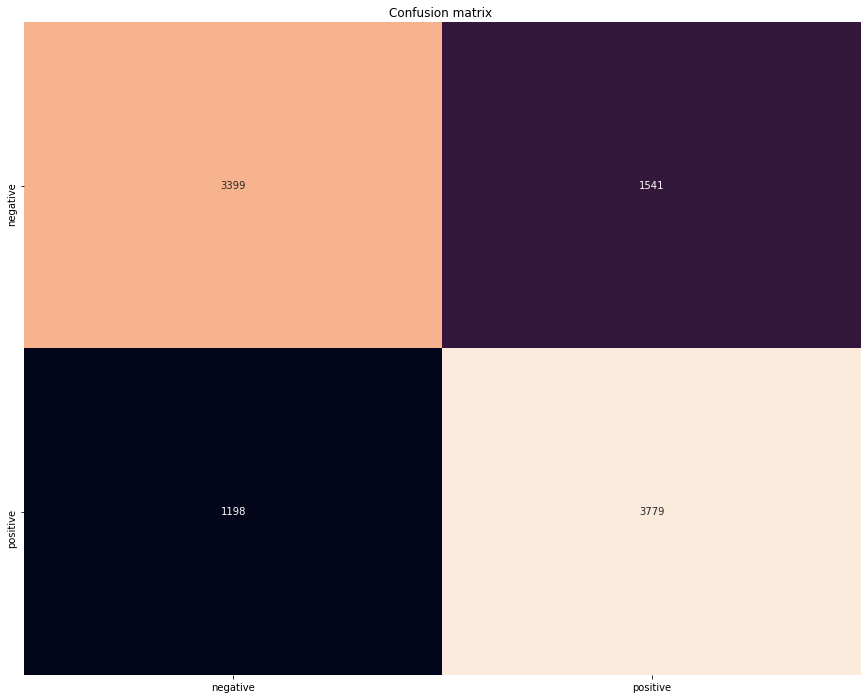









Number of features:  500
Precision:   0.81
Recall:   0.80
F1-measure:   0.80
Accuracy:   0.80
ROC-AUC  =    0.88




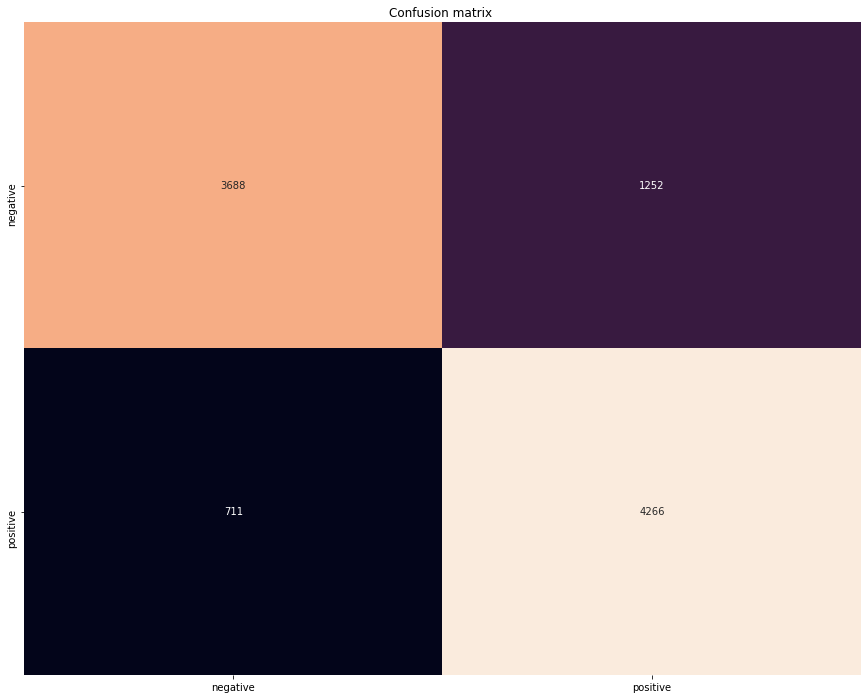









Number of features:  1000
Precision:   0.81
Recall:   0.81
F1-measure:   0.80
Accuracy:   0.81
ROC-AUC  =    0.89




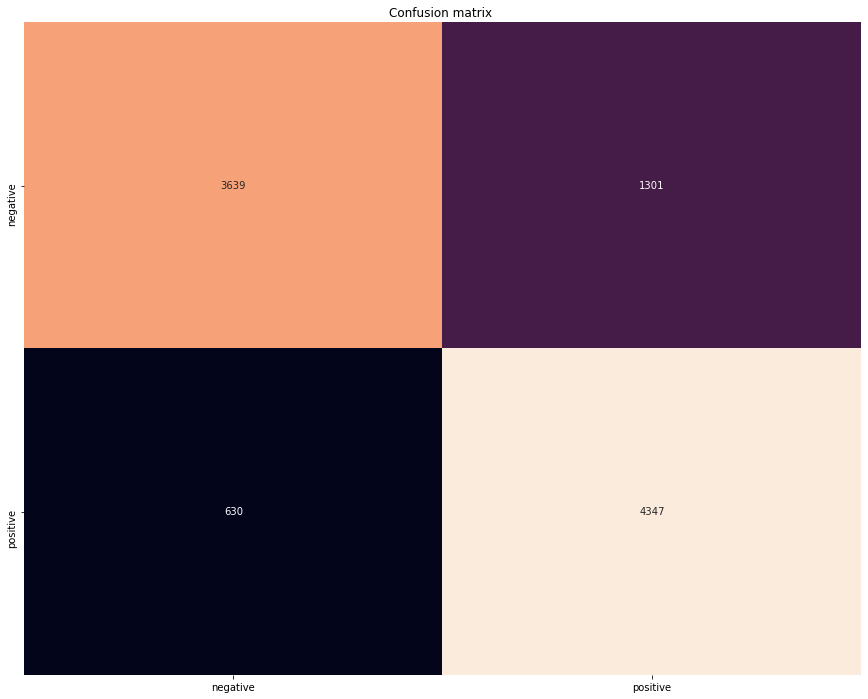









Number of features:  5000
Precision:   0.81
Recall:   0.79
F1-measure:   0.79
Accuracy:   0.79
ROC-AUC  =    0.89




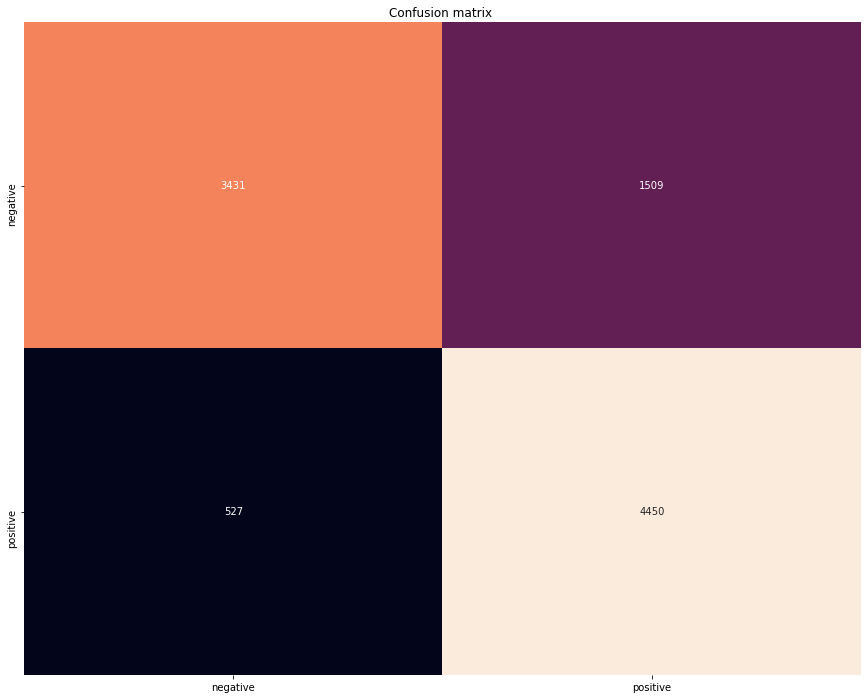









Number of features:  10000
Precision:   0.80
Recall:   0.79
F1-measure:   0.78
Accuracy:   0.79
ROC-AUC  =    0.89




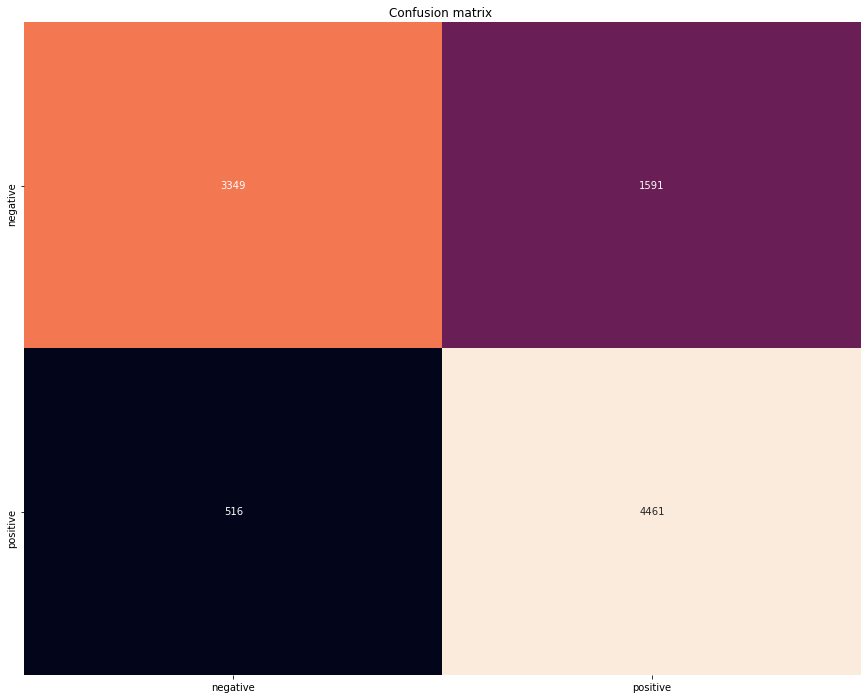









Number of features:  25000
Precision:   0.80
Recall:   0.78
F1-measure:   0.78
Accuracy:   0.78
ROC-AUC  =    0.88




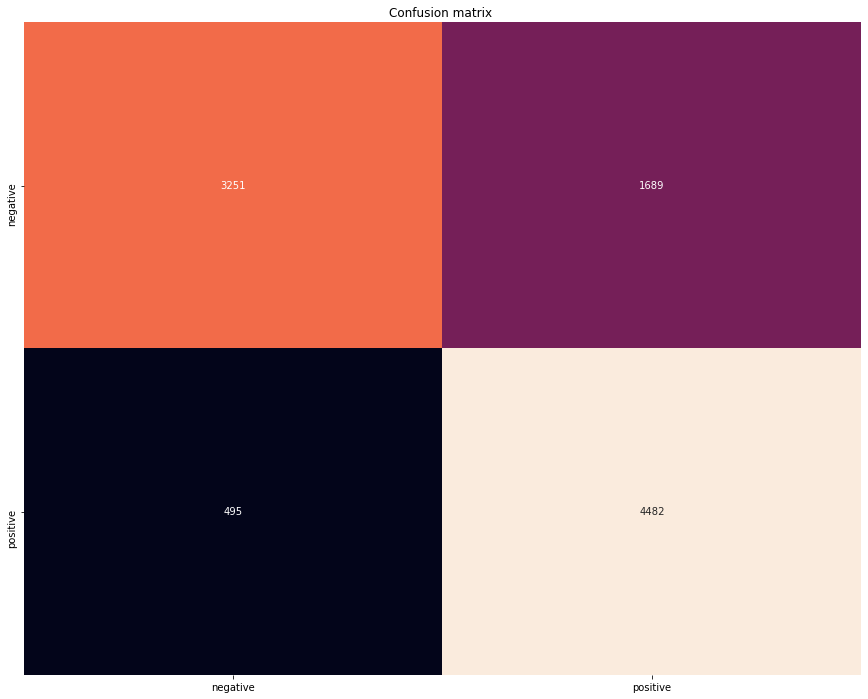









Number of features:  50000
Precision:   0.80
Recall:   0.78
F1-measure:   0.77
Accuracy:   0.78
ROC-AUC  =    0.88




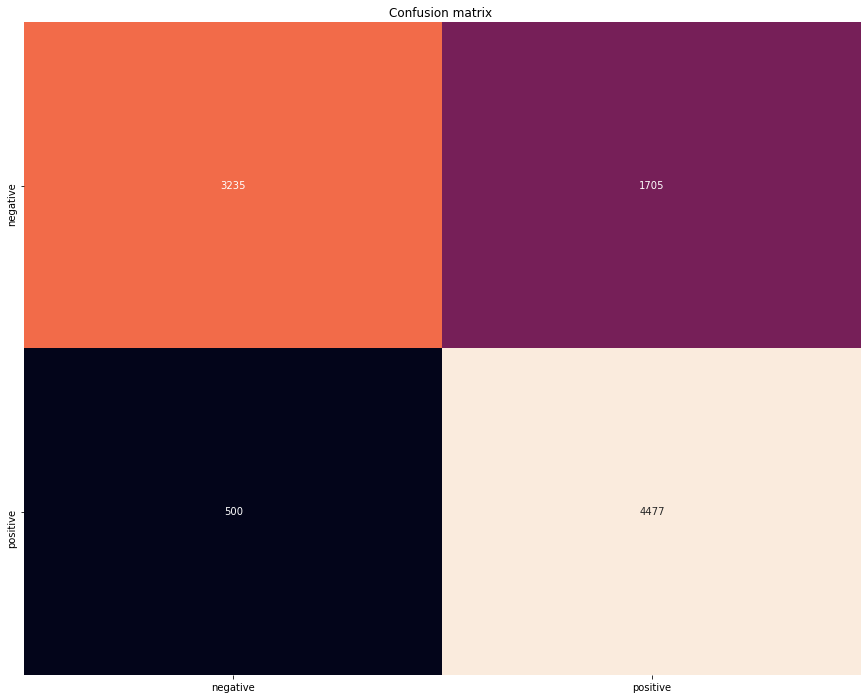









Number of features:  75000
Precision:   0.80
Recall:   0.78
F1-measure:   0.77
Accuracy:   0.78
ROC-AUC  =    0.88




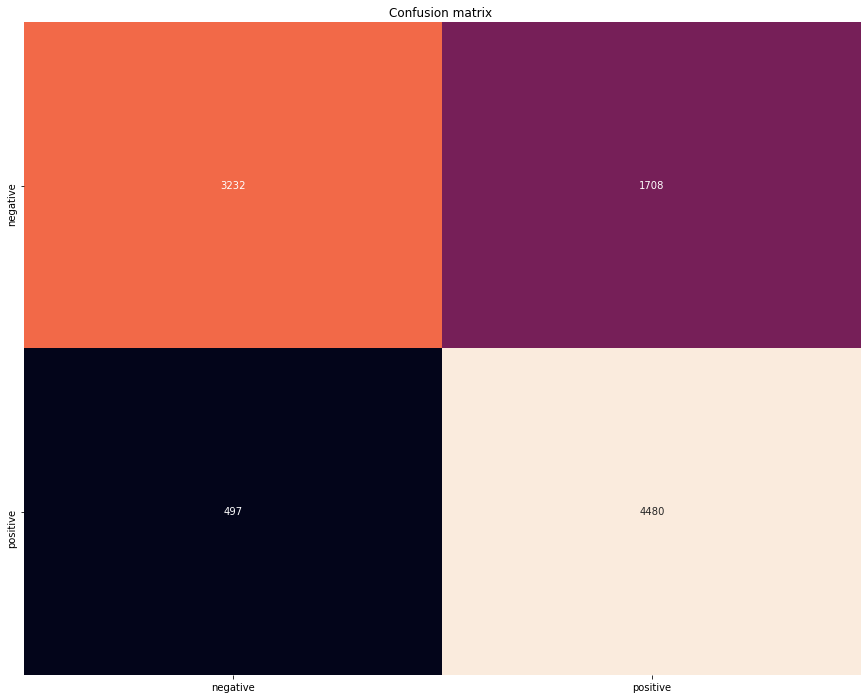









Number of features:  100000
Precision:   0.80
Recall:   0.78
F1-measure:   0.77
Accuracy:   0.78
ROC-AUC  =    0.88




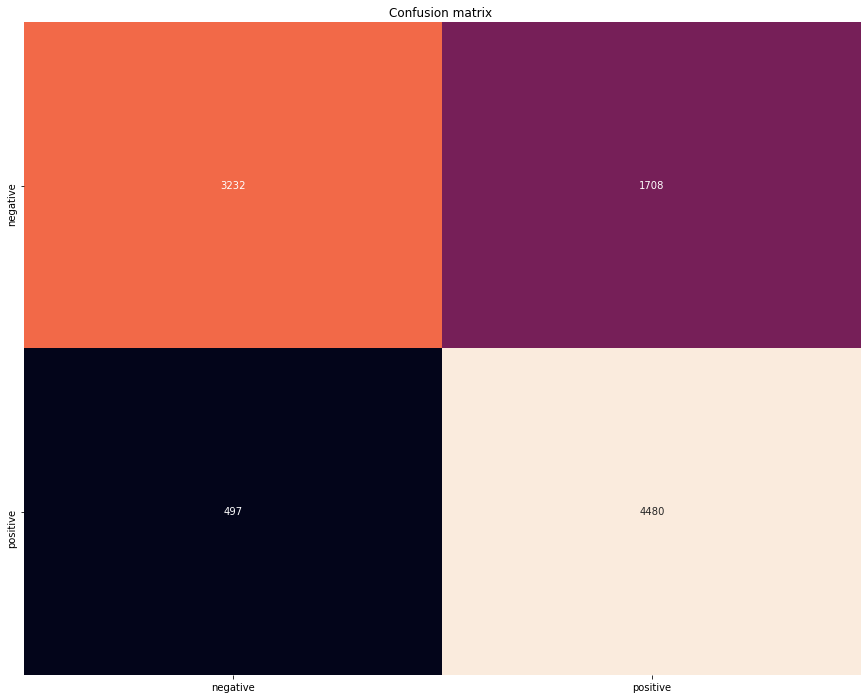

In [30]:
#используем оптимальные настройки
best_params = {'C': 0.001, 'class_weight': None, 'penalty': 'l2'}
f1s = []
word_grid = [100, 500, 1000, 5000, 10000, 25000, 50000, 75000, 100000]
for max_features in word_grid:
    vectorizer = TfidfVectorizer(max_features = max_features)
    vectorizer.fit(train_texts)
    train_X = vectorizer.transform(train_texts)
    test_X  = vectorizer.transform(test_texts)
    clf = LogisticRegression(**best_params)
    clf.fit(train_X, train_y)
    pred = clf.predict(test_X)
    proba  = clf.predict_proba(test_X)
    print('Number of features: ', max_features)
    show_results(test_y, pred, proba)
    print('\n\n\n')
    f1s.append(roc_auc_score(test_y, proba[:,1]))
    print('\n\n\n')

Для 1000 признаков метрики качества составляют F1-measure: 0.80, Accuracy: 0.81, ROC-AUC: 0.89. Это лучший результат.

## Применим для векторизации модель tf-idf с разбивкой на биграммы

Здесь применим 1000 признаков.

In [31]:
# Обучим TF-IDF на тренировочных данных
vectorizer2 = TfidfVectorizer(max_features = 1000, norm = None, ngram_range=(2, 2)) # возмем топ 1000 слов
vectorizer2.fit(train_texts)
#выведем топ 10 слов
vectorizer2.get_feature_names()[:10]

['20th centuri',
 'absolut noth',
 'academi award',
 'act bad',
 'act br',
 'act direct',
 'act film',
 'act good',
 'act great',
 'act like']

In [32]:
len(train_texts)

39665

Размерность верная. 

In [33]:
# Обучаем vectorizer на train-данных и сразу преобразем их в вектора с помощью метода fit_transform
train_X = vectorizer2.fit_transform(train_texts)
train_X.todense()[:2]

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [34]:
#применяем векторайзер к тестовым данным
test_X  = vectorizer2.transform(test_texts)

### Настроим регуляризацию модели и других параметров, применительно к биграммам

Best parameters:  {'C': 0.001, 'class_weight': None, 'penalty': 'l2'}
Precision:   0.76
Recall:   0.76
F1-measure:   0.76
Accuracy:   0.76
ROC-AUC  =    0.85




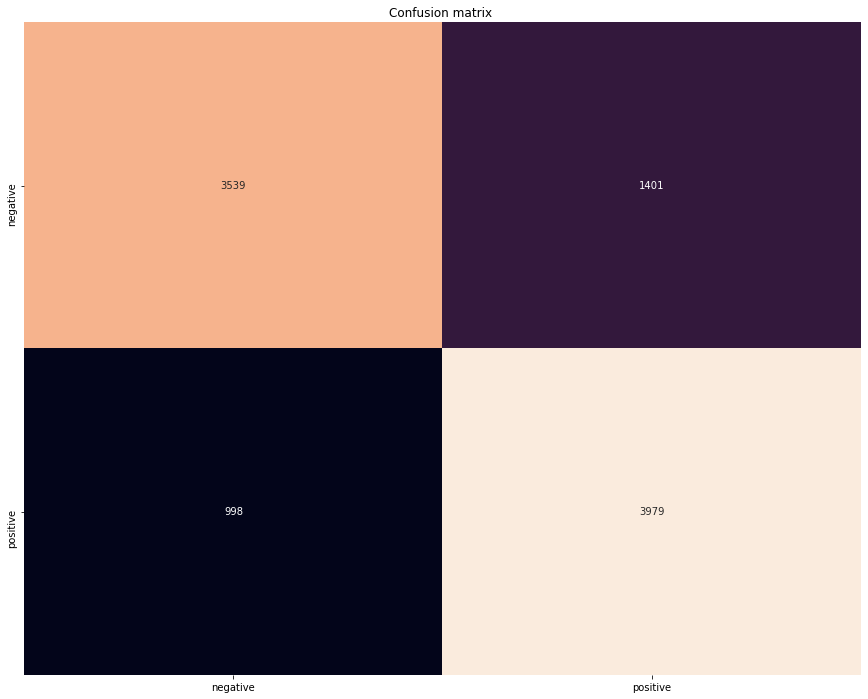

In [35]:
#C - настройка регуляризации, class_weight - балансируем распределение по классам, 
# penalty - назначаем модели регуляризации для штрафов за переобучение
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight' : ['balanced',None],\
              'penalty':['l1', 'l2', 'elasticnet']}

svr = LogisticRegression(verbose = False)
clf = GridSearchCV(svr, parameters, scoring = 'f1')
clf.fit(train_X, train_y)
pred = clf.predict(test_X)
proba  = clf.predict_proba(test_X)
print('Best parameters: ', clf.best_params_)
show_results(test_y, pred, proba)

### Подберем оптимальное количество признаков

Number of features:  100
Precision:   0.74
Recall:   0.74
F1-measure:   0.74
Accuracy:   0.74
ROC-AUC  =    0.82




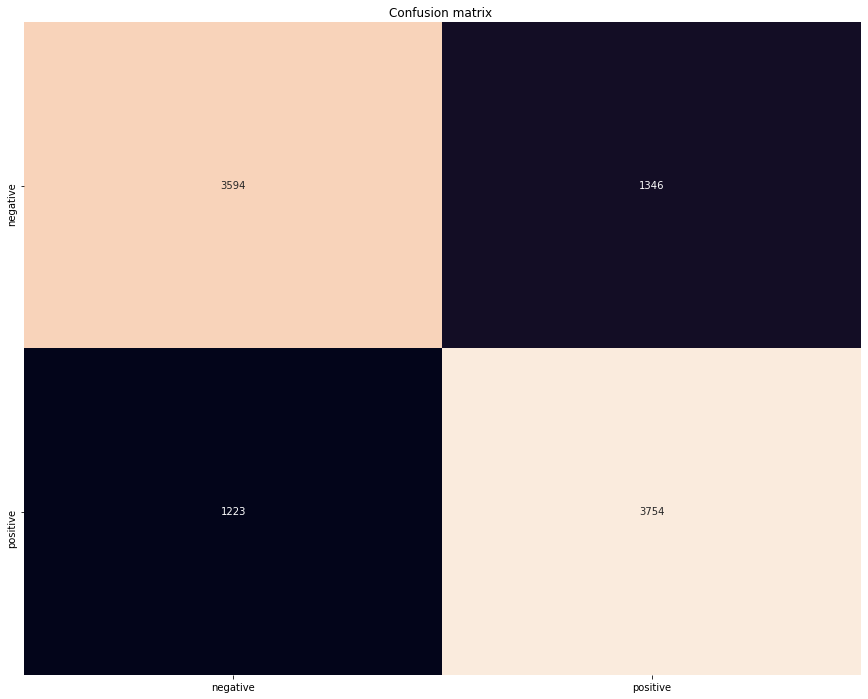









Number of features:  500
Precision:   0.83
Recall:   0.83
F1-measure:   0.83
Accuracy:   0.83
ROC-AUC  =    0.91




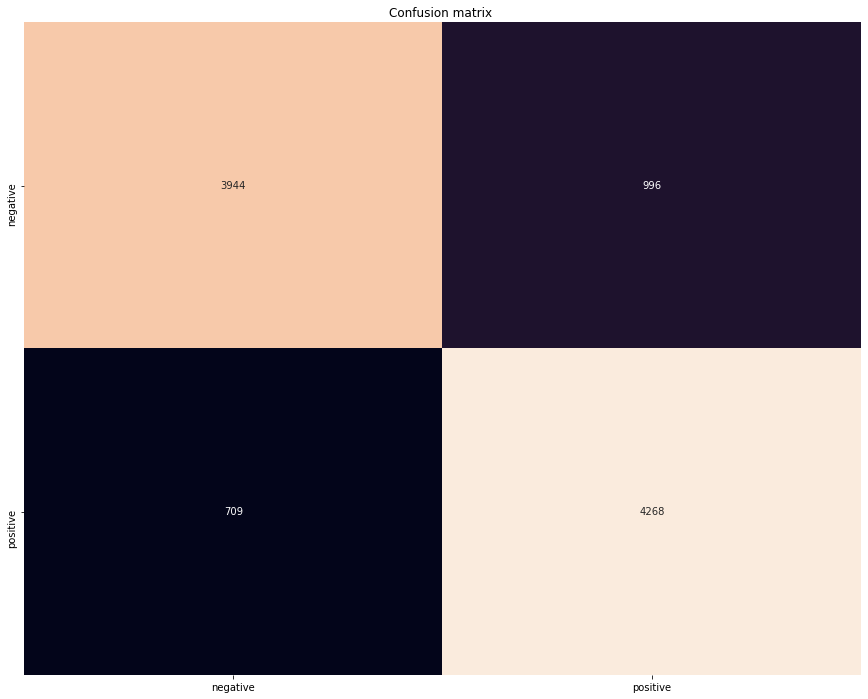









Number of features:  1000
Precision:   0.84
Recall:   0.84
F1-measure:   0.84
Accuracy:   0.84
ROC-AUC  =    0.92




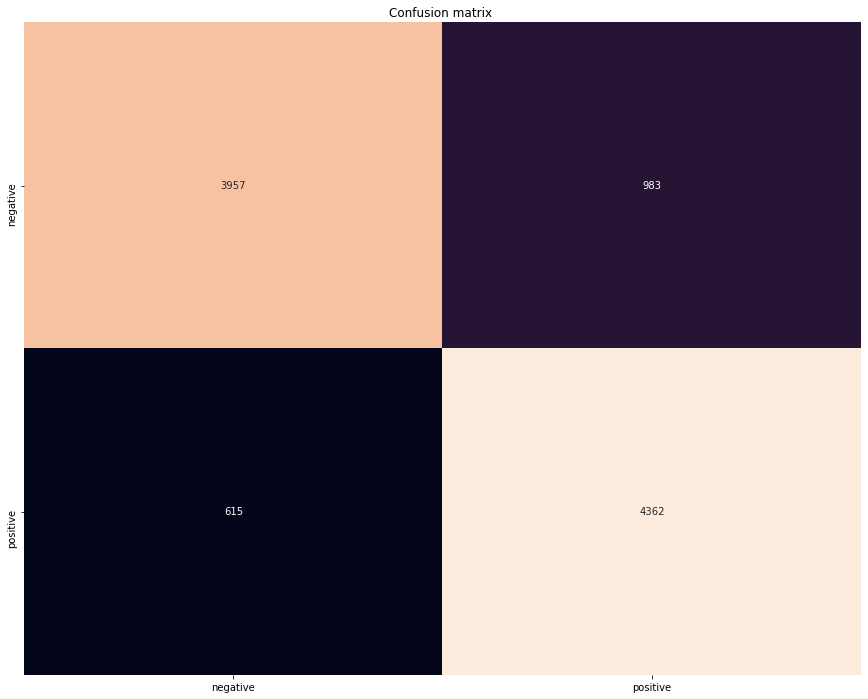









Number of features:  5000
Precision:   0.84
Recall:   0.83
F1-measure:   0.83
Accuracy:   0.84
ROC-AUC  =    0.92




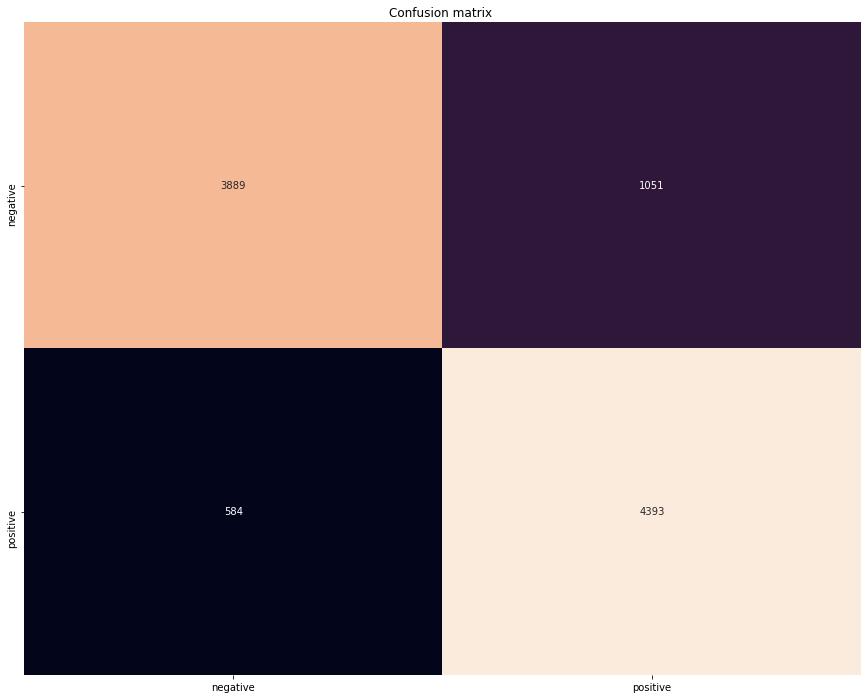









Number of features:  10000
Precision:   0.83
Recall:   0.83
F1-measure:   0.83
Accuracy:   0.83
ROC-AUC  =    0.91




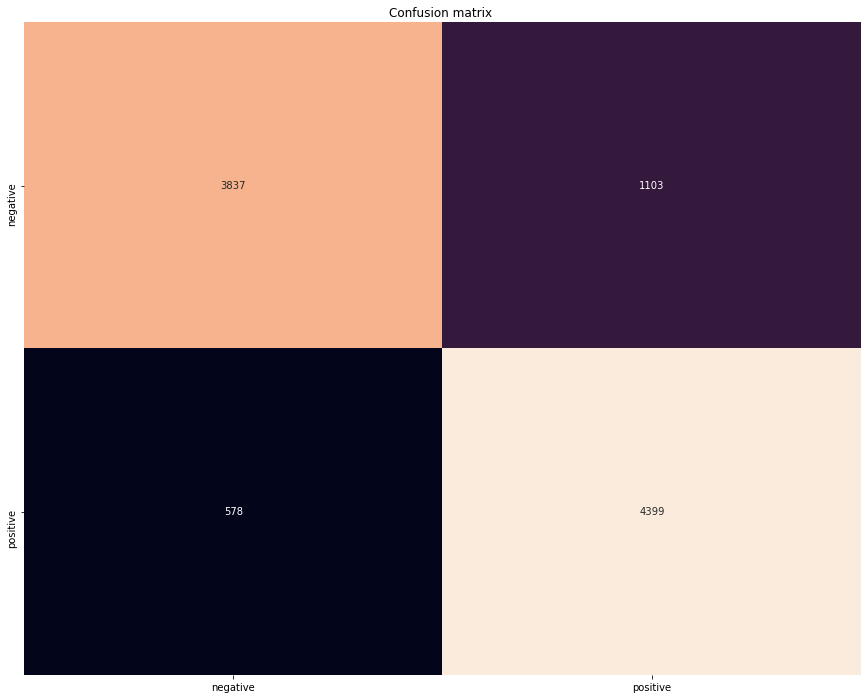









Number of features:  25000
Precision:   0.83
Recall:   0.83
F1-measure:   0.83
Accuracy:   0.83
ROC-AUC  =    0.91




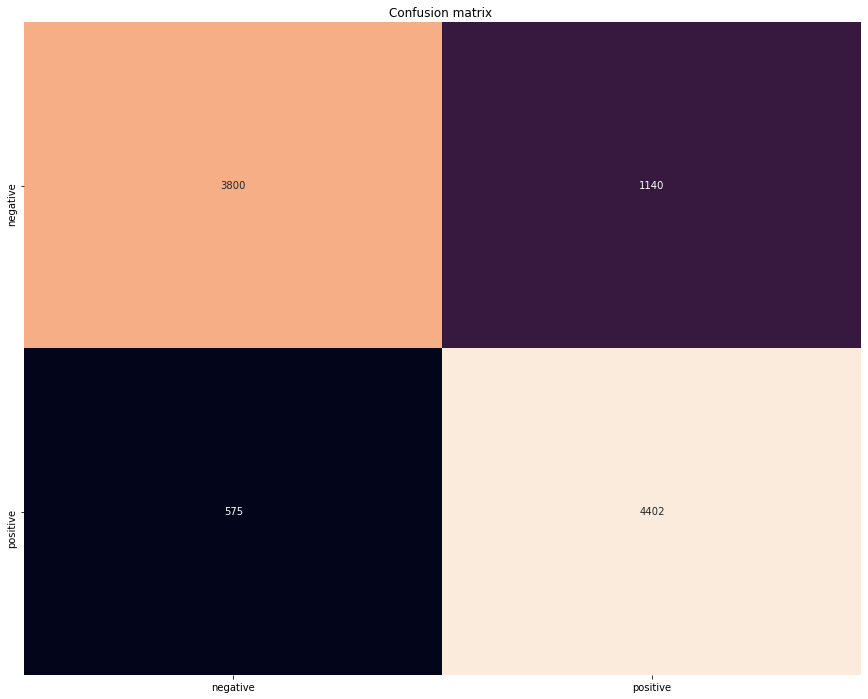









Number of features:  50000
Precision:   0.83
Recall:   0.83
F1-measure:   0.83
Accuracy:   0.83
ROC-AUC  =    0.91




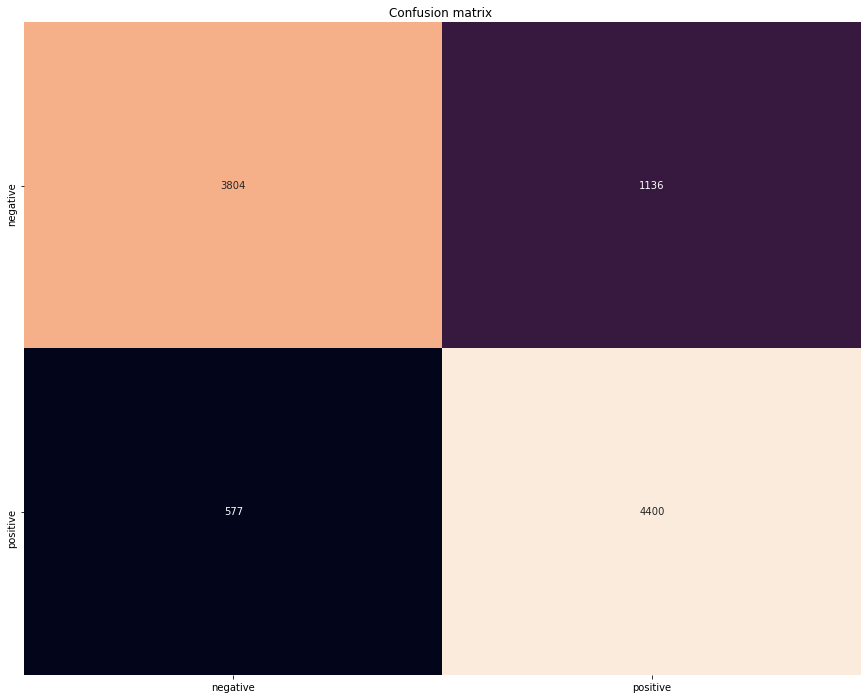









Number of features:  75000
Precision:   0.83
Recall:   0.83
F1-measure:   0.83
Accuracy:   0.83
ROC-AUC  =    0.91




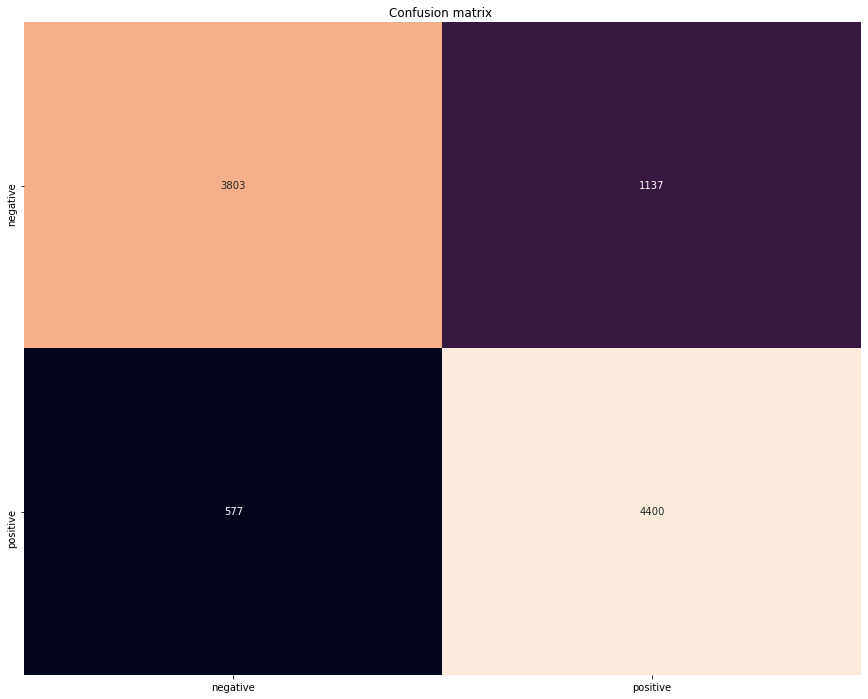









Number of features:  100000
Precision:   0.83
Recall:   0.83
F1-measure:   0.83
Accuracy:   0.83
ROC-AUC  =    0.91




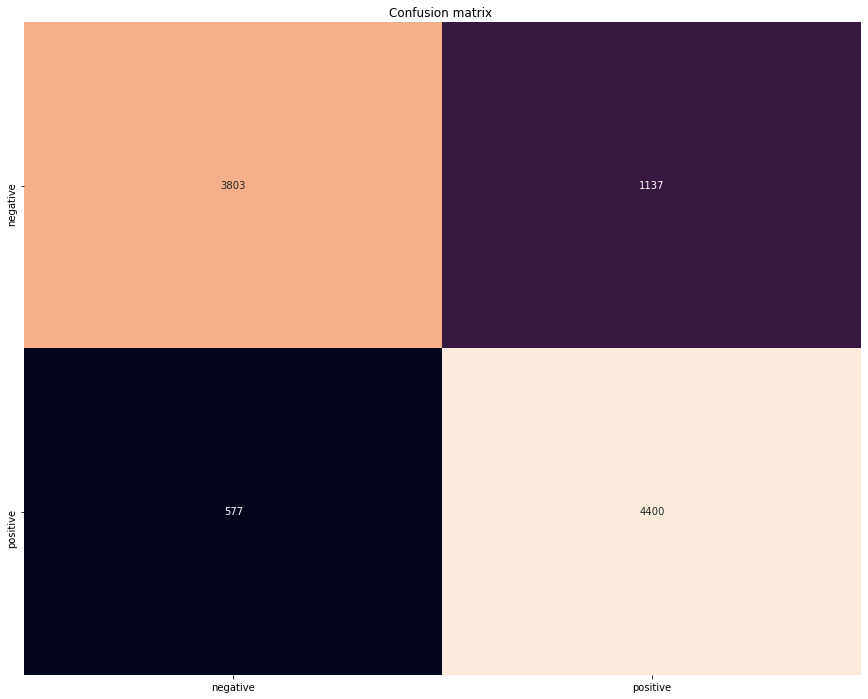

In [36]:
#используем оптимальные настройки
best_params = {'C': 0.01, 'class_weight': None, 'penalty': 'l2'}
f1s = []
word_grid = [100, 500, 1000, 5000, 10000, 25000, 50000, 75000, 100000]
for max_features in word_grid:
    vectorizer = TfidfVectorizer(max_features = max_features)
    vectorizer.fit(train_texts)
    train_X = vectorizer.transform(train_texts)
    test_X  = vectorizer.transform(test_texts)
    clf = LogisticRegression(**best_params)
    clf.fit(train_X, train_y)
    pred = clf.predict(test_X)
    proba  = clf.predict_proba(test_X)
    print('Number of features: ', max_features)
    show_results(test_y, pred, proba)
    print('\n\n\n')
    f1s.append(roc_auc_score(test_y, proba[:,1]))
    print('\n\n\n')

Для биграмм на мой взгляд оптимальное количество признаков 1000. 

## Визуализируем коэффициенты регрессии

Обучим векторайзер на 50 словах.Я в этом случае ради эксперимента оставляю регуляризацию включенной. 

In [37]:
# vectorizer3 = TfidfVectorizer(max_features = 50) # возмем топ 50 слов
# vectorizer3.fit(train_texts)

In [38]:
# # Обучаем vectorizer на train-данных и сразу преобразем их в вектора с помощью метода fit_transform
# train_X3 = vectorizer3.fit_transform(train_texts)
# #применяем векторайзер к тестовым данным
# test_X3  = vectorizer3.transform(test_texts)

Применим оптимальные настройки к логистической регрессии.

In [39]:
# #используем оптимальные настройки
# best_params = {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2'}
# clf = LogisticRegression(**best_params, random_state = 42)
# clf.fit(train_X3, train_y)
# pred = clf.predict(test_X3)
# proba  = clf.predict_proba(test_X3)
# print('Number of features: ', 50)
# show_results(test_y, pred, proba)
# print('\n\n\n')

На 50 словах метрики заметно ниже, чем на 1000.

Введем коэффициенты регрессии.

In [40]:
# clf.coef_

In [41]:
# #переведем в абсолютные величины коэффициенты
# abs_coef = []
# for i in clf.coef_:
#     abs_coef.append(abs(i)) 
# abs_coef

Не получилось перевести в нужную размерность для построения гистограмм поэтому вручную скопировал. 

In [42]:
# import matplotlib.pyplot as plt

# x = [0.18188721, 0.0577259 , 0.18556553, 0.56934414, 0.07801256,
#         0.01538114, 0.0174767 , 0.15133757, 0.0246482 , 0.23644397,
#         0.11996729, 0.04850054, 0.0747371 , 0.05667927, 0.05536795,
#         0.43640682, 0.01366617, 0.10385005, 0.1522234 , 0.36017001,
#         0.07816746, 0.08760761, 0.09524064, 0.24932568, 0.05030383,
#         0.01982757, 0.0482173 , 0.00643279, 0.1262665 , 0.20690195,
#         0.05795938, 0.08393365, 0.05227713, 0.11590917, 0.10315377,
#         0.02088882, 0.10691638, 0.13892079, 0.03385955, 0.11333474,
#         0.02219343, 0.05664099, 0.04021406, 0.06504172, 0.06345892,
#         0.02308466, 0.2230138 , 0.07078952, 0.15097281, 0.13104291]

In [43]:
# #присвоим метки для каждого коэффициента
# labels = []
# for i in range(1,51):
#     labels.append(i)

In [44]:
# #визуализируем коэффициенты
# plt.title('Коэффициенты логистической регрессии')
# plt.barh(labels, x, error_kw={'ecolor':'0.1','capsize':6},alpha=0.7,label='Абсолютные значения')
# plt.yticks(labels)
# plt.legend(loc=5)
# plt.grid(True)
# plt.show()

In [45]:
# #выведем на печать нулевой коэффициент
# clf.intercept_

**Интерпретация:**

1. Из визуализации видно, что значения коэффициентов в основном не более 0,5 и укладываются в диапазон от 0 до 0,5. Это значит, что веса признакам даны преимущественно сбалансированно и о критическом переобучении речь не идет. Вместе с тем, отмечу, что признаки могут отличаться друг от друга в 10 раз, значит веса распределены не идеально.   
2. Нулевой коэффициент имеет тот же порядок, что и коэффициенты признаков.

## Попробуем взять также 50 слов, но при векторизации выключим регуляризацию.

In [46]:
# vectorizer4 = TfidfVectorizer(max_features = 50, norm = None) # возмем топ 50 слов
# vectorizer4.fit(train_texts)

In [47]:
# # Обучаем vectorizer на train-данных и сразу преобразем их в вектора с помощью метода fit_transform
# train_X4 = vectorizer4.fit_transform(train_texts)
# #применяем векторайзер к тестовым данным
# test_X4  = vectorizer4.transform(test_texts)

In [48]:
# #используем оптимальные настройки
# best_params = {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2'}
# clf = LogisticRegression(**best_params, random_state = 42)
# clf.fit(train_X4, train_y)
# pred = clf.predict(test_X4)
# proba  = clf.predict_proba(test_X4)
# print('Number of features: ', 50)
# show_results(test_y, pred, proba)
# print('\n\n\n')

Также не высокие значения метрик.

In [49]:
# clf.coef_

In [50]:
# #переведем в абсолютные величины коэффициенты
# abs_coef = []
# for i in clf.coef_:
#     abs_coef.append(abs(i)) 
# abs_coef

In [51]:
# import matplotlib.pyplot as plt

# x = [9.47267135e-02, 5.13651378e-02, 1.25240553e-01, 3.39070388e-01,
#         3.99276046e-03, 1.21455682e-02, 1.88161991e-02, 1.03942157e-01,
#         6.96644553e-03, 1.29820367e-01, 1.95083637e-02, 3.28925729e-02,
#         3.38169714e-02, 2.65365301e-02, 6.30064276e-02, 2.68322692e-01,
#         1.20569211e-03, 2.05876046e-02, 9.67911044e-02, 1.75052492e-01,
#         4.77992442e-02, 3.47535993e-02, 7.04782640e-02, 3.89092240e-02,
#         2.50616046e-02, 1.19491268e-02, 3.07833944e-02, 5.73520988e-05,
#         6.55119324e-02, 1.17096678e-01, 1.46278387e-02, 4.02240514e-02,
#         1.85779922e-02, 8.42750469e-02, 6.47015274e-02, 3.63402294e-02,
#         2.16229286e-02, 3.85240360e-02, 4.09743715e-02, 5.66979961e-02,
#         1.48328103e-02, 3.15362211e-02, 1.70921262e-02, 3.35951280e-02,
#         1.17954952e-02, 3.29736531e-02, 1.42179778e-01, 3.88350338e-02,
#         8.34892411e-02, 7.91556198e-02]

In [52]:
# #присвоим метки для каждого коэффициента
# labels = []
# for i in range(1,51):
#     labels.append(i)

In [53]:
# #визуализируем коэффициенты
# plt.title('Коэффициенты логистической регрессии')
# plt.barh(labels, x, error_kw={'ecolor':'0.1','capsize':6},alpha=0.7,label='Абсолютные значения')
# plt.yticks(labels)
# plt.legend(loc=5)
# plt.grid(True)
# plt.show()

In [54]:
# #выведем на печать нулевой коэффициент
# clf.intercept_

1. Из визуализации видно, что значения коэффициентов в основном не более 0,3 и укладываются в диапазон от 0 до 0,3. Это значит, что веса признакам даны преимущественно сбалансированно и о критическом переобучении речь не идет. Здесь также признаки могут отличаться друг от друга в 10 раз, значит веса распределены не идеально.   
2. Нулевой коэффициент имеет тот же порядок, что и коэффициенты признаков.

## Просмотр 50 топ-слов и составление датафрейма с сортировкой по коэффициентам линейной регрессии

In [55]:
# Обучим TF-IDF на тренировочных данных
vectorizer = TfidfVectorizer(max_df = 0.60, min_df = 40, norm = None) 
vectorizer.fit(train_texts)
#выведем топ 10 слов
vectorizer.get_feature_names()[:10]

['00',
 '13th',
 '18th',
 '1920s',
 '1930s',
 '1940s',
 '1950s',
 '1960s',
 '1970s',
 '1980s']

In [56]:
vectorizer.get_feature_names()
len(vectorizer.get_feature_names())

7324

In [57]:
# Обучаем vectorizer на train-данных и сразу преобразем их в вектора с помощью метода fit_transform
train_X = vectorizer.fit_transform(train_texts)

In [58]:
#используем оптимальные настройки
best_params = {'C': 0.001, 'class_weight': None, 'penalty': 'l2'}
lr = LogisticRegression(**best_params, random_state = 42)
lr.fit(train_X, train_y)

LogisticRegression(C=0.001, random_state=42)

In [59]:
lr.coef_

array([[-0.00891579, -0.01655175, -0.00746311, ..., -0.01540493,
        -0.00757743, -0.00045913]])

In [60]:
lr.intercept_

array([0.04330327])

In [61]:
#переведем массив в список
lr_coef_ = lr.coef_.tolist()
#т.к. получился список списков переведем в один список и посмотрим длину
lr_coef_=sum(lr_coef_, [])
len(lr_coef_)

7324

In [62]:
#создадим датафрейм из слов и коэффициентов
data = pd.DataFrame({'words': vectorizer.get_feature_names(), 'coef' : lr_coef_})
#создадим датафрейм и топ 50 слов по самым большим коэффициентам
top50 = data.sort_values(by = 'coef', ascending = False).head(50)
top50['coef'] = round(top50['coef'], 3)
top50.head()

,words,coef
2278,excel,0.189
2854,great,0.183
4777,perfect,0.163
2173,enjoy,0.144
806,brilliant,0.134


In [63]:
import matplotlib.pyplot as plt
#присвоим метки для каждого коэффициента
labels = []
for i in range(1,51):
    labels.append(i)

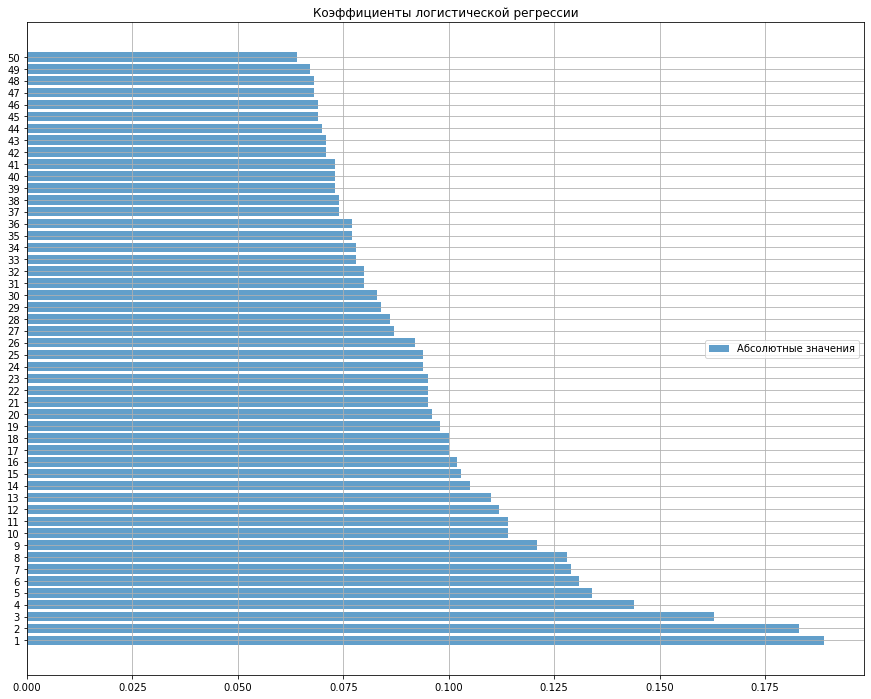

In [64]:
#визуализируем коэффициенты
plt.title('Коэффициенты логистической регрессии')
plt.barh(labels, top50['coef'], error_kw={'ecolor':'0.1','capsize':6},alpha=0.7,label='Абсолютные значения')
plt.yticks(labels)
plt.legend(loc=5)
plt.grid(True)
plt.show()

**Интерпретация:**

1. Из визуализации видно, что значения коэффициентов находятся в диапазоне 0,06 - 0,175. Это значит, что веса признакам даны преимущественно сбалансированно и о критическом переобучении речь не идет. 
2. Нулевой коэффициент имеет тот же порядок, что и коэффициенты признаков.